# getting data ready

## imports and setup

 ### import required packages

In [1]:
import os
import math
import obspy
import pickle
import datetime
import scipy
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from datetime import timedelta
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from earthquake import Earthquake
import util
import pandas as pd
from multiprocessing import Pool
import random

from cmcrameri import cm
import matplotlib as mpl

In [4]:
list_tpmax = []
list_mags = []
list_mag_types = []
list_eq = []
eqs = {}
count = 0

### potential other parameters to use

In [5]:
#parameters = [
#[1,0.1,19,0,'eq_object_1s_bandpass_01_19_snr_20_blank_0'],
#[1,0.1,19,0.05,'eq_object_1s_bandpass_01_19_snr_20_blank_005'],
#[1,0.1,19,0.1,'eq_object_1s_bandpass_01_19_snr_20_blank_01'],
#[1,0.1,19,0.25,'eq_object_1s_bandpass_01_19_snr_20_blank_025'],
#[1,0.1,19,0.5,'eq_object_1s_bandpass_01_19_snr_20_blank_05'],
#[4,0.1,19,0,'eq_object_4s_bandpass_01_19_snr_20_blank_0'],
#[4,0.1,19,0.05,'eq_object_4s_bandpass_01_19_snr_20_blank_005'],
#[4,0.1,19,0.1,'eq_object_4s_bandpass_01_19_snr_20_blank_01'],
#[4,0.1,19,0.25,'eq_object_4s_bandpass_01_19_snr_20_blank_025'],
#[4,0.1,19,0.5,'eq_object_4s_bandpass_01_19_snr_20_blank_05'],
#[2,0.1,19,0.5,'eq_object_2s_bandpass_01_19_snr_20'],
#[3,0.1,19,0.5,'eq_object_3s_bandpass_01_19_snr_20']]
#[0.5,0.1,19,0,'eq_object_05s_bandpass_01_19_snr_20_blank_0'],
#[0.5,0.1,19,0.05,'eq_object_05s_bandpass_01_19_snr_20_blank_005'],
#[0.5,0.1,19,0.1,'eq_object_05s_bandpass_01_19_snr_20_blank_01'],
#[0.5,0.1,19,0.25,'eq_object_05s_bandpass_01_19_snr_20_blank_025']
#]


 ###  function definitions

In [7]:
def gen_bs_data(x,y):
    x_bs = []
    y_bs = []
    for _ in range(0, len(x)):
        n = random.randint(0, len(x)-1)
        x_bs.append(x[n])
        y_bs.append(y[n])
    return x_bs, y_bs

def get_average(list_data):
    if len(list_data)>=0:
        mean_tp = np.mean(list_data) 
        std_tp = np.std(list_data) 
        y_tp = [] 
        for j in list_data: 
            if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:
                y_tp.append(math.log(j, 10))
            elif len(list_data)==1:
                y_tp.append(math.log(j, 10))
        if math.isnan(np.median(y_tp))==False:  
            tp_ave = (np.median(y_tp))
            return tp_ave
    else:
        return None

def get_average_iv2(list_data, list_dist, n=2):
    if len(list_data)>=0:
        dist = []
        for d in list_dist:
            dist.append(float(str(np.array(d))[:-3]))
        dist = np.array(dist)
        iv2 = np.array(list_data)
        #print(iv2,dist)
        boolarray = iv2 != None
        norm_data = (dist[boolarray]**n)*iv2[boolarray]
        mean_iv2 = np.mean(norm_data) 
        std_iv2 = np.std(norm_data) 
        y_iv2 = [] 
        for j in norm_data:
            if j>=0 and j!=None:   
                if j > mean_iv2-10*std_iv2 and j < mean_iv2 + 10*std_iv2:
                    y_iv2.append(math.log(j, 10))
                elif len(norm_data)==1:
                    y_iv2.append(math.log(j, 10))
        if math.isnan(np.median(y_iv2))==False:  
            iv2_ave = (np.median(y_iv2))
            return iv2_ave
    else:
        return None

def load_from_object(p):
    fn = p[-1]
    print(fn)
    list_tpmax = []
    list_tcmax = []
    list_mags = []
    list_mag_types = []
    list_iv2 = []
    list_pgd = []
    folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/')
    for eq_no in range(0, len(folders)):
        if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl'):
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
                #return eq
            try:
                if eq.calculated_params['tau_p_max'] != [] and eq.calculated_params['tau_c'] != [] and eq.calculated_params['iv2'] != [] and eq.calculated_params['pgd'] != []:
                    tp_ave = get_average(eq.calculated_params['tau_p_max'])
                    tc_ave = get_average(eq.calculated_params['tau_c'])
                    iv2_ave = get_average_iv2(eq.calculated_params['iv2'], eq.calculated_params['iv2_dist'], n = 2)
                    pgd_ave = get_average_iv2(eq.calculated_params['pgd'], eq.calculated_params['pgd_distances'], n=1.38)
                    if tp_ave != None and tc_ave != None and iv2_ave != None and pgd_ave != None:
                        list_tpmax.append(tp_ave)
                        list_tcmax.append(tc_ave)
                        list_iv2.append(iv2_ave)
                        list_pgd.append(pgd_ave)
                        list_mags.append(eq.event_stats['eq_mag'])
                        list_mag_types.append(eq.event_stats['eq_mag_type'])
                    else:
                        print('none')
            except:
                print(eq_no)
                continue
    folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/')
    for eq_no in range(0, len(folders)):
        if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'+folders[eq_no]+'/'+fn+'.pkl'):
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
                #return eq
            try:
                if eq.calculated_params['tau_p_max'] != [] and eq.calculated_params['tau_c'] != [] and eq.calculated_params['iv2'] != [] and eq.calculated_params['pgd'] != []:
                    tp_ave = get_average(eq.calculated_params['tau_p_max'])
                    tc_ave = get_average(eq.calculated_params['tau_c'])
                    iv2_ave = get_average_iv2(eq.calculated_params['iv2'], eq.calculated_params['iv2_dist'], n = 2)
                    pgd_ave = get_average_iv2(eq.calculated_params['pgd'], eq.calculated_params['pgd_distances'], n=1.38)
                    if tp_ave != None and tc_ave != None and iv2_ave != None and pgd_ave != None:
                        list_tpmax.append(tp_ave)
                        list_tcmax.append(tc_ave)
                        list_iv2.append(iv2_ave)
                        list_pgd.append(pgd_ave)
                        list_mags.append(eq.event_stats['eq_mag'])
                        list_mag_types.append(eq.event_stats['eq_mag_type'])
                    else:
                        print('none')
            except:
                print('big', eq_no)
                continue
    folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2005_2018_global_m5/')
    for eq_no in range(0, len(folders)):
        if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2005_2018_global_m5/'+folders[eq_no]+'/'+fn+'.pkl'):
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2005_2018_global_m5/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
                #return eq
            try:
                if eq.calculated_params['tau_p_max'] != [] and eq.calculated_params['tau_c'] != [] and eq.calculated_params['iv2'] != [] and eq.calculated_params['pgd'] != []:
                    tp_ave = get_average(eq.calculated_params['tau_p_max'])
                    tc_ave = get_average(eq.calculated_params['tau_c'])
                    iv2_ave = get_average_iv2(eq.calculated_params['iv2'], eq.calculated_params['iv2_dist'], n = 2)
                    pgd_ave = get_average_iv2(eq.calculated_params['pgd'], eq.calculated_params['pgd_distances'], n=1.38)
                    if tp_ave != None and tc_ave != None and iv2_ave != None and pgd_ave != None:
                        list_tpmax.append(tp_ave)
                        list_tcmax.append(tc_ave)
                        list_iv2.append(iv2_ave)
                        list_pgd.append(pgd_ave)
                        list_mags.append(eq.event_stats['eq_mag'])
                        list_mag_types.append(eq.event_stats['eq_mag_type'])
                    else:
                        print('none')
            except:
                print('2005', eq_no)
                continue
    return list_tpmax, list_tcmax, list_iv2, list_pgd, list_mags, list_mag_types


## if need to run new

first set this to True -- this is to avoid accidently overwriting!!!

In [8]:
run_new = False

### set parameters to use

In [9]:
parameters = [[0.3,0.1,19,0,'eq_object_03s_bandpass_01_19_snr_20_blank_0_new_snr20']]
p = parameters[0]

### run calculation and produce lists

In [176]:
if run_new == True: 
    list_tpmax, list_tcmax, list_iv2, list_pgd, list_mags, list_mag_types = load_from_object(p)

eq_object_03s_bandpass_01_19_snr_20_blank_0_new_snr20


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


398
746


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


none
none
1535
none
none
3421
none
4898
none
5282
6273
6790
none
none
none
none
none
none
none
2005 939
2005 1072
none
none
none
none
2005 2531
none
none
2005 2758
none
2005 2846
none
none
none
none
2005 3740
none
2005 4086
none
none
none
none
none
none
none
none
none
none
none
none
2005 5821
none
none
none
2005 5939
2005 5945
2005 5980


### save as dataframe

In [37]:
''

''

In [177]:
if run_new == True: 
    df = pd.DataFrame({'mag': list_mags, 'mag_types': list_mag_types, 'tp': list_tpmax, 'tc': list_tcmax, 'iv2': list_iv2, 'pgd':list_pgd})
    df.to_pickle(f"/home/earthquakes1/homes/Rebecca/phd/seismo_det/other/earthquake_averages_dataframes/{p[-1]}_2.pkl")

## if just need to load already arranged info

### load from dataframe

In [10]:
df = pd.read_pickle(f"/home/earthquakes1/homes/Rebecca/phd/seismo_det/other/earthquake_averages_dataframes/{p[-1]}_2.pkl")

In [18]:
list_tpmax = np.array(df['tp'])
list_tcmax = np.array(df['tc'])
list_iv2 = np.array(df['iv2'])
#list_pgd = np.array(df['pgd'])
list_mags = np.array(df['mag'])

# plotting

## best fit parameters

## set up colormap

In [12]:
cmap = cm.lajolla # define the colormap
# extract all colors from the .oslo map
cmaplist = [cmap(i) for i in range(0,cmap.N,int((max(list_mags)-3)*10))]

# create the new map
new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 200, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

tick_loc_mag = np.array([3,4,5,6,7])
tick_loc_norm = (tick_loc_mag-3)/(7.1-3)

 ## 2d plots

In [13]:
result = scipy.stats.linregress(list_mags,list_pgd)
a = result.slope
b = result.intercept

NameError: name 'list_pgd' is not defined

In [182]:
a

0.5136234500248551

In [183]:
b

-5.17600164390635

In [14]:
tp_a = 0.14
tp_b = -0.91
tc_a = 0.20
tc_b = -1.13
iv2_a = 0.75
iv2_b = -9.88
pgd_a = 0.49
pgd_b = -5.12
#pgd_a = 0.60
#pgd_b = -4.52

In [15]:
%matplotlib inline

In [16]:
tp = list_tpmax-(tp_a*(list_mags)+tp_b)
tc = list_tcmax-(tc_a*(list_mags)+tc_b)
iv2 = list_iv2-(iv2_a*(list_mags)+iv2_b)
pgd = list_pgd-(pgd_a*(list_mags)+pgd_b)

NameError: name 'list_pgd' is not defined

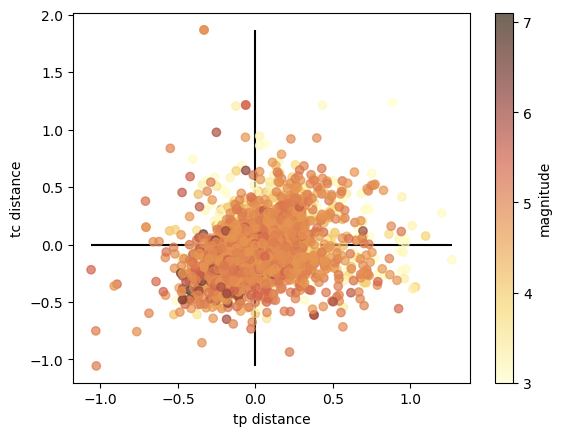

In [198]:
plt.hlines([0], min(tp), max(tp), zorder = 1, color = 'k')
plt.vlines([0], min(tc), max(tc), zorder = 1, color = 'k')

plt.scatter(tp, tc, c = (list_mags - 3)/max(list_mags-3), cmap=new_cmap, alpha = 0.7)
plt.ylabel('tc distance')
plt.xlabel('tp distance')

cbar = plt.colorbar(ticks=tick_loc_norm, label = 'magnitude')
cbar.set_ticklabels(tick_loc_mag)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/residual_plots/tp_tc.pdf')

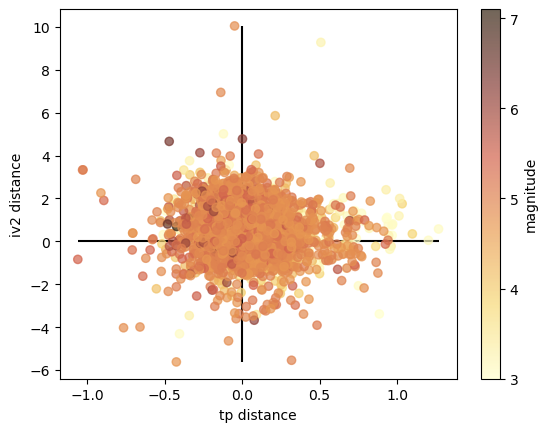

In [199]:
plt.hlines([0], min(tp), max(tp), zorder = 1, color = 'k')
plt.vlines([0], min(iv2), max(iv2), zorder = 1, color = 'k')

plt.scatter(tp, iv2, c = (list_mags - 3)/max(list_mags-3), cmap=new_cmap, alpha = 0.7)
plt.ylabel('iv2 distance')
plt.xlabel('tp distance')
cbar = plt.colorbar(ticks=tick_loc_norm, label = 'magnitude')
cbar.set_ticklabels(tick_loc_mag)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/residual_plots/tp_iv2.pdf')

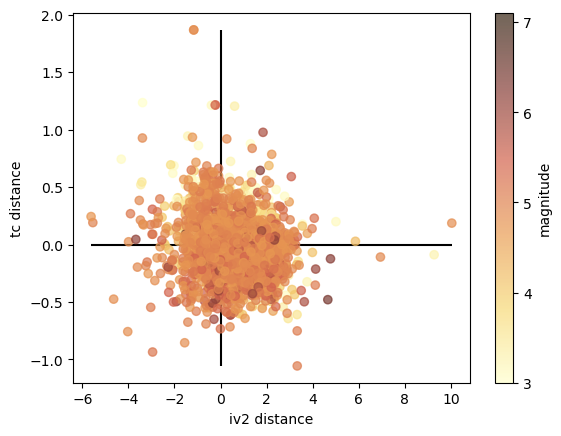

In [201]:
plt.vlines([0], min(tc), max(tc), zorder = 1, color = 'k')
plt.hlines([0], min(iv2), max(iv2), zorder = 1, color = 'k')

plt.scatter(iv2, tc, c = (list_mags - 3)/max(list_mags-3), cmap=new_cmap, alpha = 0.7)
plt.ylabel('tc distance')
plt.xlabel('iv2 distance')
cbar = plt.colorbar(ticks=tick_loc_norm, label = 'magnitude')
cbar.set_ticklabels(tick_loc_mag)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/residual_plots/iv2_tc.pdf')

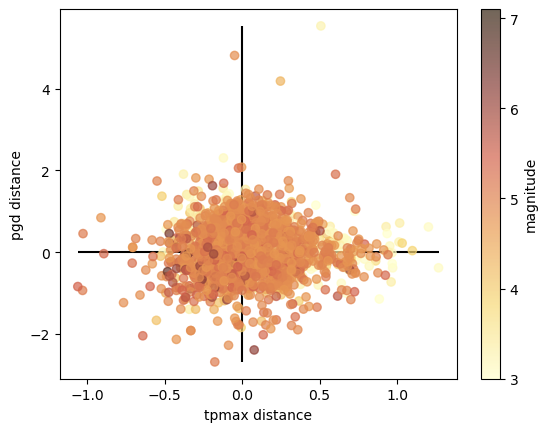

In [202]:
plt.hlines([0], min(tp), max(tp), zorder = 1, color = 'k')
plt.vlines([0], min(pgd), max(pgd), zorder = 1, color = 'k')

plt.scatter(tp, pgd, c = (list_mags - 3)/max(list_mags-3), cmap=new_cmap, alpha = 0.7)
plt.xlabel('tpmax distance')
plt.ylabel('pgd distance')
cbar = plt.colorbar(ticks=tick_loc_norm, label = 'magnitude')
cbar.set_ticklabels(tick_loc_mag)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/residual_plots/tp_pgd.pdf')

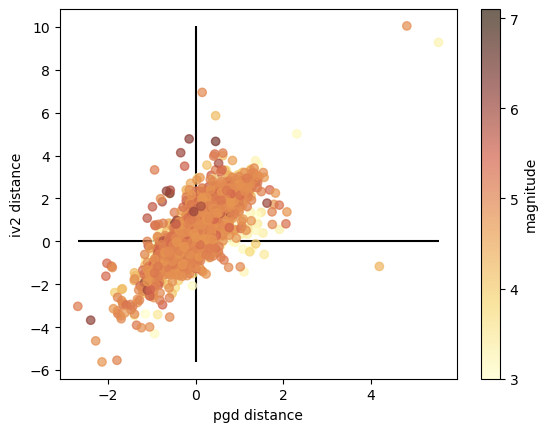

In [203]:
plt.vlines([0], min(iv2), max(iv2), zorder = 1, color = 'k')
plt.hlines([0], min(pgd), max(pgd), zorder = 1, color = 'k')

plt.scatter(pgd, iv2, c = (list_mags - 3)/max(list_mags-3), cmap=new_cmap, alpha = 0.7)
plt.ylabel('iv2 distance')
plt.xlabel('pgd distance')
cbar = plt.colorbar(ticks=tick_loc_norm, label = 'magnitude')
cbar.set_ticklabels(tick_loc_mag)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/residual_plots/iv2_pgd.pdf')

In [192]:
np.mean(pgd)

0.05014576115739646

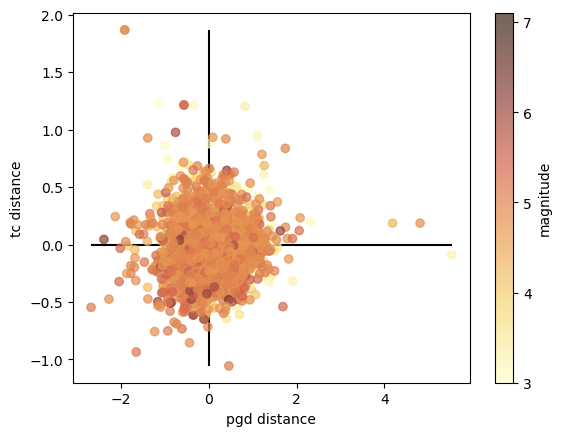

In [204]:
plt.vlines([0], min(tc), max(tc), zorder = 1, color = 'k')
plt.hlines([0], min(pgd), max(pgd), zorder = 1, color = 'k')

plt.scatter(pgd, tc, c = (list_mags - 3)/max(list_mags-3), cmap=new_cmap, alpha = 0.7)
plt.ylabel('tc distance')
plt.xlabel('pgd distance')
cbar = plt.colorbar(ticks=tick_loc_norm, label = 'magnitude')
cbar.set_ticklabels(tick_loc_mag)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/residual_plots/pgd_tc.pdf')

residuals

In [19]:
tp_r = np.sum(abs(list_tpmax-(tp_a*(list_mags)+tp_b)))
tc_r = np.sum(abs(list_tcmax-(tc_a*(list_mags)+tc_b)))
iv2_r = np.sum(abs(list_iv2-(iv2_a*(list_mags)+iv2_b)))
#pgd_r = np.sum(abs(list_pgd-(pgd_a*(list_mags)+pgd_b)))

In [22]:
iv2_r

3350.252722455145

## 3d plot

In [17]:
%matplotlib qt  
# make in external window so interactive
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
p = ax.scatter3D(list_iv2-(iv2_a*(list_mags)+iv2_b), 
             list_tcmax-(tc_a*(list_mags)+tc_b), 
             list_tpmax-(tp_a*(list_mags)+tp_b), 
             c = (list_mags - 3)/max(list_mags-3), cmap=new_cmap,
            alpha = 0.7)

# label plot
ax.set_ylabel('distance tc')
ax.set_xlabel('distance iv2')
ax.set_zlabel('distance tp')

cbar = fig.colorbar(p, ticks=tick_loc_norm, label = 'magnitude')
cbar.set_ticklabels(tick_loc_mag)
# lines at 0
#ax.plot([-6,0,6],[0,0,0],[0,0,0], c='k')
ax.plot([0,0,0],[-1,0,1],[0,0,0], c='k')
ax.plot([0,0,0],[0,0,0],[-1,0,1.5], c='k')

In [18]:
%matplotlib qt  
# make in external window so interactive
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
p = ax.scatter3D(list_iv2, 
             list_mags, 
             list_tpmax-(tp_a*(list_mags)+tp_b), 
            alpha = 0.7)

# label plot
ax.set_ylabel('distance tc')
ax.set_xlabel('iv2')
ax.set_zlabel('magntiude')

cbar = fig.colorbar(p, ticks=tick_loc_norm, label = 'magnitude')
cbar.set_ticklabels(tick_loc_mag)
# lines at 0
ax.plot([-6,0,6],[0,0,0],[0,0,0], c='k')
ax.plot([0,0,0],[-1,0,1],[0,0,0], c='k')
ax.plot([0,0,0],[0,0,0],[-1,0,1.5], c='k')